# Sprint 2: Unsupervised learning

In dit deel wordt de K-means clustering methode gebruikt om categorieën te bepalen waartoe de klachten behoren. Deze keer wordt aan unsupervised learning gedaan, wat betekent dat de categorieën niet vooraf bepaald worden, in tegenstelling tot bij supervised learning. We laten de models dus zelf bepalen wat de onderverdelingen zijn.

K-means is een methode die de data opdeelt in k clusters. Initieel worden k punten gekozen als clusters, willekeurig of aan de hand van een algoritme. Vervolgens wordt de cluster waartoe een ander punt behoort bepaald door de afstand van het punt tot het gemiddelde van de cluster. Dit proces wordt verschillende keren herhaald waarna de configuratie met de kleinste totale variantie van de punten in de clusters gekozen wordt als beste configuratie.

Een manier om de beste waarde voor k te kiezen is de *elbow method*. Hierbij worden verschillende waarden voor k getest en wordt de verandering in de totale variantie van de data geplot (hoe groter k, hoe kleiner de totale varantie). Deze totale variantie (inertia) is de som van de kwadraten van de afstanden van de punten tot het midden van hun cluster. De beste waarde voor k is dan de 'elleboog' van de geplotte functie. Dit is het punt waar de vermindering van de variantie significant groter is dan die bij het volgende punt.

## Data pre-processing
De data moet eerst geschikt gemaakt worden voor clustering, aan de hand van pre-processing technieken. Dit wordt op dezelfde manier gedaan als in de vorige sprint. Om te beginnen plaatsen we enkele gelijkaardige productcategorieën onder dezelfde noemer.

In [13]:
complaints_df.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

<Figure size 720x360 with 0 Axes>

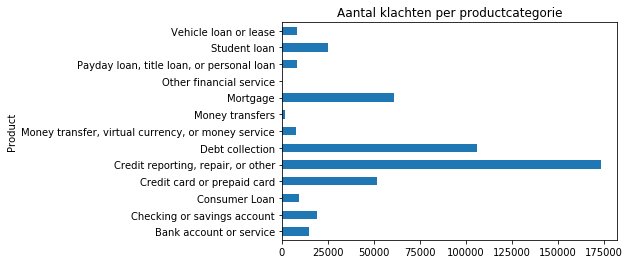

In [141]:
product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per productcategorie", legend=None)

Zo te zien is de data zeer ongebalanceerd. Om de data wat meer gebalanceerd te maken en om de tijd die K-means nodig heeft om de clustering uit te voeren wat te beperken, zullen we per productcategorie maximum 5000 klachten behouden. Deze klachten worden willekeurig gekozen door de **sample** methode.

In [30]:
def sampling_k_elements(category, k=5000):
    if len(category) < k:
        return category
    return category.sample(k)

balanced = complaints_df.groupby('Product').apply(sampling_k_elements).reset_index(drop=True)

<Figure size 720x360 with 0 Axes>

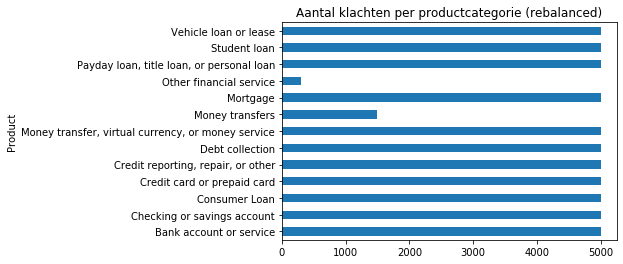

In [142]:
balanced_counts = pd.DataFrame({'Count': balanced.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
balanced_counts.plot.barh(title="Aantal klachten per productcategorie (rebalanced)", legend=None)

Met deze gebalanceerde data zal het al een stuk gemakkelijker zijn om clusters te vinden.

Nu passen we onder andere tokenization en stemming (werkwoorden en andere woorden reduceren tot hun stamvorm) toe op de narratives en verwijderen we stopwoorden.

In [144]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    # stopwoorden verwijderen en woorden die bestaan uit maximum 3 karakters weglaten
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    # werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return ' ' . join(result)

In [38]:
balanced['Narrative_processed'] = balanced['Narrative'].apply(processing)
balanced[['Narrative','Narrative_processed']].head()

,Narrative,Narrative_processed
0,"Being a first time, single mother, I had to ma...",time singl mother make decis overdraft protect...
1,My parents bank with a well known bank that I ...,parent bank know bank fear retribut account pa...
2,The US Bank cancelled my Checking Account 's O...,bank cancel check account overdraft coverag no...
3,I had a levy from a debt collector and law fir...,levi debt collector firm base place bank ameri...
4,I contacted USAA bank to dispute a charge afte...,contact usaa bank disput charg compani fail wo...


De *narrative_processed* kolom kan nu gebruikt worden om feature extraction op toe te passen.

## Feature extraction
Om de woorden om te zetten in bruikbare data maken we nieuwe features aan de hand van een CountVectorizer. Deze converteert de token sets naar een ijle matrix van token counts. De matrix is ijl (sparse) omdat de meeste elementen nul zijn of dicht bij nul liggen.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.97)
X = vectorizer.fit_transform(balanced['Narrative_processed'])

Vervolgens wordt het aantal unieke woorden bepaald en wordt de data geplot aan de hand van een scatterplot.

Er zijn 7777 unieke woorden.


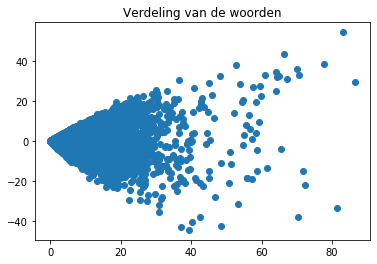

In [121]:
from sklearn.decomposition import TruncatedSVD
print('Er zijn %d unieke woorden.' % X.shape[1])
tsvd = TruncatedSVD(n_components=2).fit(X)
tsvd_2d = tsvd.transform(X)
plt.title('Verdeling van de woorden')
plt.scatter(tsvd_2d[:, 0], tsvd_2d[:, 1])

## K-means
Nu kan de K-means methode toegepast worden op de matrix. We beginnen met 20 verschillende waarden voor k uit te testen, om daarna aan de hand van de *elbow method* de beste waarde te kiezen. Initieel worden dus onderverdelingen gemaakt met 1 tot en met 20 clusters.
Dit proces werd opgedeeld in twee cellen omdat we onzeker waren over de uitvoertijd van de code voor alle 20 waarden voor k. Dat is ook de reden waarom we slechts met een deel van de dataset werken; na enkele pogingen met de volledige dataset en met meer waarden voor k bleek dat dit niet in enkele uren uitgevoerd kon worden.

In [46]:
%%time

from sklearn.cluster import KMeans
#List voor bijhouden van WCSS (Within-Cluster-Sum-of-Squares):
inertia = []
k_min = 1
k_max = 11
for i in range(k_min, k_max):
    print(i)
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
Wall time: 2h 1min 50s


In [47]:
%%time

k_min = 11
k_max = 21
for i in range(k_min, k_max):
    print(i)
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

11
12
13
14
15
16
17
18
19
20
Wall time: 3h 17min 2s


De totale varianties van de punten in de clusters per waarde voor k bevinden zich nu in de lijst *inertia*. Dit staat ons toe om deze in een grafiek te zetten en de *elbow* van de functie te vinden.

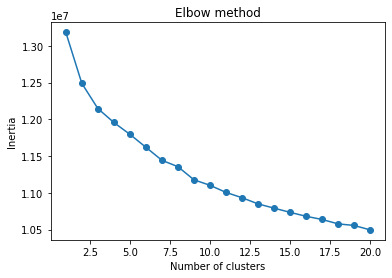

In [61]:
plt.plot(range(1,21), inertia, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Zo te zien is de *elbow* in deze grafiek niet erg duidelijk. We kiezen hier de waarde 9 voor k omdat de vermindering in inertia bij k=9 toch duidelijk groter is dan de vermindering bij k=10.
Nu voeren we K-means opnieuw uit met k=9 en fitten we het model.

In [63]:
k = 9
model = KMeans(n_clusters = k, n_jobs = -1)
model.fit(X)

Vervolgens kunnen we de clusters visualiseren in een scatterplot.

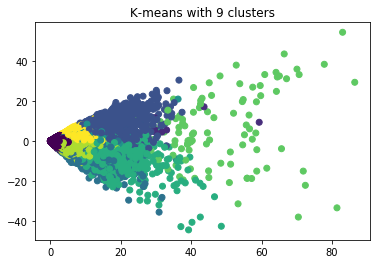

In [122]:
plt.title('K-means with 9 clusters')
plt.scatter(tsvd_2d[:, 0], tsvd_2d[:, 1], c=model.labels_)
plt.show()

Enerzijds ligt het merendeel van de data zeer dicht bij elkaar. Dit zal ook te merken zijn wanneer we de meest voorkomende woorden bepalen bij elke cluster. Anderzijds zijn er toch enkele outliers.

Ten slotte trachten we de inhoud van de clusters beter te visualiseren. Dit wordt gedaan aan de hand van een **wordcloud**. Dit houdt rekening met het aantal voorkomens van een woord om de grootte ervan in de wordcloud te bepalen.

Meest voorkomende woorden per cluster:
Cluster 0:


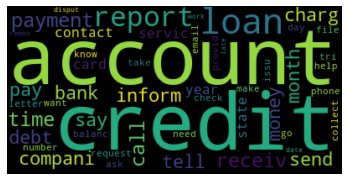

Cluster 1:


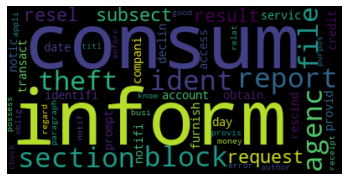

Cluster 2:


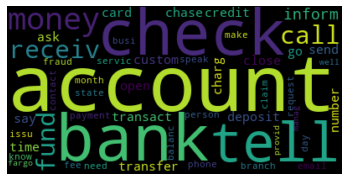

Cluster 3:


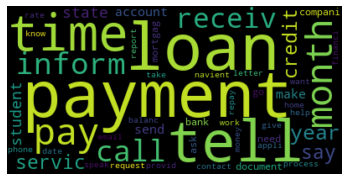

Cluster 4:


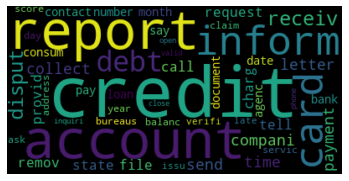

Cluster 5:


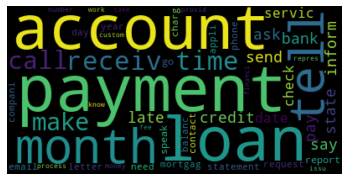

Cluster 6:


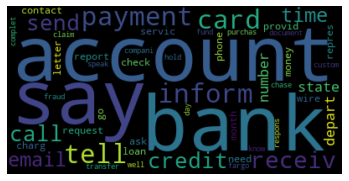

Cluster 7:


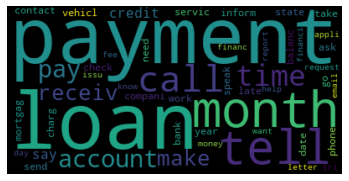

Cluster 8:


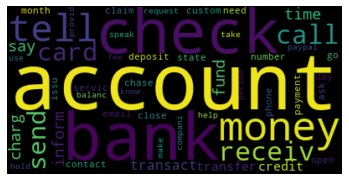

In [145]:
from wordcloud import WordCloud
print("Meest voorkomende woorden per cluster:")
cluster_centers = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
counts = vectorizer.vocabulary_
for i in range(k):
    print("Cluster %d:" % i)
    most_frequent = [];
    for j in cluster_centers[i, :50]:
        most_frequent.append(terms[j])
    text = " ".join(most_frequent)
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In de wordclouds komen vaak dezelfde woorden terug. Dit is analoog met wat er te zien is in het scatterplot.